# Data Cleaning 

### From Kaggle Kernels:
#### Extensive Sberbank Exploratory Analysis:
**source:** https://www.kaggle.com/captcalculator/a-very-extensive-sberbank-exploratory-analysis/comments#latest-185178

* 37 observations where life_sq is greater than full_sq.
* A vast majority of the apartments have three rooms or less.
* Look to see how life sq ~ price changes based on sub-area or distance to kremlin
* Home price does seem to increase with population density.
* There does not appear to be a relationship between the mean home price in a district and the district’s share of working age population.
* Surprisingly, there is little to no correlation between price and the school variables. The school variables however are highly correlated with each other, indicating that we would not want to use all of them in a linear regression model due to multicollinearity.
* homes with >3 top 20 universities show signs of correlation, but only one house fits that description.
* raions that have a top 25 cultural object have a median home sale price that is higher by 1.2 million (using this feature as a factor)
* strong positive correlation between sport_objects_raion and price_doc

#### Simple Exploration Notebook - Sberbank
**source:** https://www.kaggle.com/sudalairajkumar/simple-exploration-notebook-sberbank/comments/notebook

* overall increasing trend in price as floor_num increases. A sudden increase in the house price is also observed at floor 18.
* Individual houses seems to be costlier, check price of 0 floor houses.

#### Map visualizations with external shapefile
**source:** https://www.kaggle.com/jtremoureux/map-visualizations-with-external-shapefile/notebook

* replace regions with map shapefile coordinates



## Import Libraries & Data

In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from datetime import datetime
from matplotlib import pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
# load dataset
train_df = pd.read_csv("../Sberbank/train.csv", parse_dates=['timestamp'], index_col=False, low_memory=False)
test_df = pd.read_csv("../Sberbank/test.csv", parse_dates=['timestamp'], index_col=False, low_memory=False)
macro_df = pd.read_csv("../Sberbank/macro.csv", parse_dates=['timestamp'], index_col=False, low_memory=False)

### Merge Train & Test

In [3]:
frames = [train_df, test_df]

df = pd.concat(frames)

### Add Macro

In [4]:
# add macro data to train/test data

train_df = pd.merge(train_df, macro_df, how='left', on='timestamp')
test_df = pd.merge(test_df, macro_df, how='left', on='timestamp')

df = pd.merge(df, macro_df, how='left', on='timestamp')

### Features of Importance

In [5]:
features = pd.read_csv('../EDA/submissions/features.csv', squeeze=True)
features = features.ravel()

In [6]:
features

array(['floor', 'max_floor', 'state', 'indust_part',
       'school_education_centers_raion', '16_29_female',
       'build_count_monolith', 'metro_km_walk', 'kindergarten_km',
       'school_km', 'green_zone_km', 'public_transport_station_min_walk',
       'ttk_km', 'ID_big_road2', 'ID_bus_terminal', 'oil_chemistry_km',
       'fitness_km', 'swim_pool_km', 'public_healthcare_km',
       'workplaces_km', 'mosque_km', 'theater_km', 'catering_km',
       'green_part_500', 'office_sqm_500', 'cafe_count_500_price_4000',
       'cafe_count_500_price_high', 'church_count_500',
       'leisure_count_500', 'cafe_count_1000_price_high', 'prom_part_1500',
       'cafe_sum_1500_max_price_avg', 'big_church_count_1500',
       'mosque_count_1500', 'cafe_count_2000',
       'cafe_sum_2000_min_price_avg', 'big_church_count_2000',
       'prom_part_3000', 'cafe_count_3000_price_2500', 'sport_count_3000',
       'cafe_count_5000_price_2500', 'cafe_count_5000_price_high',
       'mosque_count_5000', 'rt

## Manual Imputing/Removal of Observations:

In [7]:
def missing_count(df):
    features = {}
    for feature in df:
        if np.sum(df[feature].isnull()) > 0:
            features[feature] = np.sum(df[feature].isnull())
    return features

In [8]:
missing_count(df[features])

{'build_count_monolith': 6209,
 'cafe_sum_1500_max_price_avg': 5020,
 'cafe_sum_2000_min_price_avg': 2149,
 'floor': 167,
 'max_floor': 9572,
 'metro_km_walk': 59,
 'product_type': 33,
 'state': 14253}

drop features with missing values in < 100 obs (.33%):

In [9]:
train_df = train_df.loc[train_df['product_type'].notnull()]
train_df = train_df.loc[train_df['metro_km_walk'].notnull()]
train_df = train_df.loc[train_df['floor'].notnull()]

In [10]:
missing_count(train_df[features])

train_df[features].columns

Index([u'floor', u'max_floor', u'state', u'indust_part',
       u'school_education_centers_raion', u'16_29_female',
       u'build_count_monolith', u'metro_km_walk', u'kindergarten_km',
       u'school_km', u'green_zone_km', u'public_transport_station_min_walk',
       u'ttk_km', u'ID_big_road2', u'ID_bus_terminal', u'oil_chemistry_km',
       u'fitness_km', u'swim_pool_km', u'public_healthcare_km',
       u'workplaces_km', u'mosque_km', u'theater_km', u'catering_km',
       u'green_part_500', u'office_sqm_500', u'cafe_count_500_price_4000',
       u'cafe_count_500_price_high', u'church_count_500', u'leisure_count_500',
       u'cafe_count_1000_price_high', u'prom_part_1500',
       u'cafe_sum_1500_max_price_avg', u'big_church_count_1500',
       u'mosque_count_1500', u'cafe_count_2000',
       u'cafe_sum_2000_min_price_avg', u'big_church_count_2000',
       u'prom_part_3000', u'cafe_count_3000_price_2500', u'sport_count_3000',
       u'cafe_count_5000_price_2500', u'cafe_count_5000_pr

### Cafe

In [11]:
df.loc[df['cafe_sum_1500_max_price_avg'].notnull() & df['price_doc'].notnull(), ['cafe_sum_1500_max_price_avg','price_doc']].corr()

,cafe_sum_1500_max_price_avg,price_doc
cafe_sum_1500_max_price_avg,1.000000,0.105952
price_doc,0.105952,1.000000


In [12]:
df[['cafe_sum_1500_max_price_avg', 'cafe_sum_1500_min_price_avg','price_doc']].corr()

,cafe_sum_1500_max_price_avg,cafe_sum_1500_min_price_avg,price_doc
cafe_sum_1500_max_price_avg,1.000000,0.981789,0.105952
cafe_sum_1500_min_price_avg,0.981789,1.000000,0.104644
price_doc,0.105952,0.104644,1.000000


Drop `df['cafe_sum_1500_min_price_avg']` as min and max are essentially the same are essentially the same feature.

#### Impute Missing `cafe_sum_1500_max_price_avg` observations.

Can we use the other cafe values to better predict the missing values in sum_1500_max?

In [13]:
cafe = ['cafe_sum_500_min_price_avg', 'cafe_sum_500_max_price_avg',
      'cafe_avg_price_500', 'cafe_sum_1000_min_price_avg','cafe_sum_1000_max_price_avg', 
      'cafe_avg_price_1000', 'cafe_sum_1500_min_price_avg', 'cafe_sum_1500_max_price_avg', 
      'cafe_avg_price_1500', 'cafe_sum_2000_min_price_avg', 'cafe_sum_2000_max_price_avg', 
      'cafe_avg_price_2000', 'cafe_sum_3000_min_price_avg', 'cafe_sum_3000_max_price_avg',
      'cafe_avg_price_3000',  'cafe_sum_5000_min_price_avg', 'cafe_sum_5000_max_price_avg',
      'cafe_avg_price_5000','cafe_count_5000_price_high','cafe_count_500', 'cafe_count_500_na_price',
        'cafe_count_500_price_500', 'cafe_count_500_price_1000',
       'cafe_count_500_price_1500', 'cafe_count_500_price_2500',
       'cafe_count_500_price_4000', 'cafe_count_500_price_high', 'cafe_count_1000', 
       'cafe_count_1000_na_price', 'cafe_count_1000_price_500',
       'cafe_count_1000_price_1000', 'cafe_count_1000_price_1500',
       'cafe_count_1000_price_2500', 'cafe_count_1000_price_4000',
       'cafe_count_1000_price_high','cafe_count_1500',
       'cafe_count_1500_na_price',
       'cafe_count_1500_price_500', 'cafe_count_1500_price_1000',
       'cafe_count_1500_price_1500', 'cafe_count_1500_price_2500',
       'cafe_count_1500_price_4000', 'cafe_count_1500_price_high', 'cafe_count_2000', 
       'cafe_count_2000_na_price', 'cafe_count_2000_price_500',
       'cafe_count_2000_price_1000', 'cafe_count_2000_price_1500',
       'cafe_count_2000_price_2500', 'cafe_count_2000_price_4000',
       'cafe_count_2000_price_high', 'cafe_count_3000', 'cafe_count_3000_na_price',
       'cafe_count_3000_price_500', 'cafe_count_3000_price_1000',
       'cafe_count_3000_price_1500', 'cafe_count_3000_price_2500',
       'cafe_count_3000_price_4000', 'cafe_count_3000_price_high','cafe_count_5000',
       'cafe_count_5000_na_price', 'cafe_count_5000_price_500',
       'cafe_count_5000_price_1000', 'cafe_count_5000_price_1500',
       'cafe_count_5000_price_2500', 'cafe_count_5000_price_4000',
       'cafe_count_5000_price_high']

In [14]:
cafe_impfeats = missing_cafe_df.apply(lambda x: np.sum(x.notnull())).sort_values(ascending=False) > 4000
cafe_impfeats = cafe_impfeats.loc[cafe_impfeats]
cafe_impfeats = cafe_impfeats.keys().ravel()

NameError: name 'missing_cafe_df' is not defined

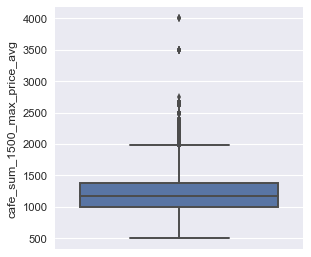

In [15]:
plt.figure(figsize=(4,4), dpi=80)
sns.boxplot(df.loc[df['cafe_sum_1500_max_price_avg'].notnull(), 'cafe_sum_1500_max_price_avg'], orient='vertical', whis=1.6)

##### remove outlier values

In [16]:
def sd_range(df, feature, sd):
    return df.loc[(df[feature] - np.mean(df[feature])).abs() / np.std(df[feature]) < sd]

def outliers(df, feature, arange):
    df[feature] = df.loc[df[feature].notnull()]
    for sd in arange:
        remaining = sd_range(df, feature, sd)
        percent = np.float(len(remaining))/np.float(len(df[feature]))
        print 'Within {0} SD, Remaining Obs: {1}, Percent: {2}'.format(sd,len(remaining),round(percent, 4)*100)
    
# def sd_range(df, feature, sd):
#     return df.loc[(df[feature] - np.mean(df[feature])).abs() / np.std(df[feature]) < sd]

In [19]:
# print outliers(train_df, 'floor', np.arange(1.5,4,0.5))

train_df = sd_range(train_df, 'floor', 3)

remove observations outside 3 SD.

In [24]:
frames = [train_df, test_df]

df = pd.concat(frames)

### Floor

In [21]:
df.loc[df['floor'].notnull()].corr()['floor'].sort_values()

build_count_1946-1970                    -0.141914
build_count_block                        -0.138960
market_count_5000                        -0.114753
state                                    -0.107982
public_transport_station_km              -0.104179
public_transport_station_min_walk        -0.104179
hospital_beds_raion                      -0.100973
sport_count_5000                         -0.093445
prom_part_5000                           -0.091387
preschool_km                             -0.084468
build_count_brick                        -0.083782
school_km                                -0.083164
sport_count_3000                         -0.081205
metro_min_walk                           -0.080413
metro_km_walk                            -0.080413
mkad_km                                  -0.079928
market_count_2000                        -0.077432
ts_km                                    -0.076820
shopping_centers_km                      -0.075829
trc_sqm_5000                   

In [22]:
df.shape

(38133, 391)

In [23]:
df.loc[df['full_sq'] == 0]

,0_13_all,0_13_female,0_13_male,0_17_all,0_17_female,0_17_male,0_6_all,0_6_female,0_6_male,16_29_all,...,provision_retail_space_modern_sqm,turnover_catering_per_cap,theaters_viewers_per_1000_cap,seats_theather_rfmin_per_100000_cap,museum_visitis_per_100_cap,bandwidth_sports,population_reg_sports_share,students_reg_sports_share,apartment_build,apartment_fund_sqm
17932,900,435,465,1150,553,597,489,236,254,2155,...,NaN,10311.0,NaN,0.44784,NaN,398451.0,28.2,NaN,46080.0,229294.8
24296,506,245,261,646,311,336,275,133,143,3796,...,NaN,10311.0,NaN,0.44784,NaN,398451.0,28.2,NaN,46080.0,229294.8
30935,3681,1787,1894,4724,2283,2441,2041,976,1065,7467,...,NaN,10805.0,NaN,0.45888,NaN,463938.0,NaN,NaN,NaN,234576.9


In [25]:
# Cleaning values with incorrect information 
df.loc[df['state'] == 33, 'state'] = 3
df = df.loc[df['id'] != 24718] 
df = df.loc[df['floor'] != 0] 

df.loc[df['build_year'] == 20052009, 'build_year'] = 2009
df.loc[df['build_year'] == 215, 'build_year'] = 2015
df.loc[df['build_year'] == 4965, 'build_year'] = 1965
df.loc[df['build_year'] == 1691, 'build_year'] = 1961
# df.loc[df['build_year'] == 0, 'build_year'] = df['year']
# df.loc[df['build_year'] == 1, 'build_year'] = df['year']
# df.loc[df['build_year'] == 2, 'build_year'] = df['year']
# df.loc[df['build_year'] == 3, 'build_year'] = df['year']
df.loc[df['build_year'] == 20, 'build_year'] = np.nan
df.loc[df['build_year'] == 71, 'build_year'] = np.nan

df.loc[df['build_year'] < 1800, 'build_year'] = np.nan
df.loc[13120, 'build_year'] = 1970 # entered under kitch-sq column
df.loc[11523, 'kitch_sq'] = df.loc[11523, 'kitch_sq'] / 100
rows = (df['kitch_sq'] > df['full_sq']) & (df['kitch_sq'] > 100)
df.loc[rows, 'kitch_sq'] = np.nan 

In [26]:
# set rows where rows where full_sq and life_sq are both 0 to null.

df.loc[(df['full_sq'] == 0) | (df['life_sq'] == 0), ['full_sq', 'life_sq']] = np.nan

### Material

In [27]:
# Assign to nan as there is only one observation in both train and test sets.

df.loc[df['material'] == 3, 'material'] = np.nan

### Max Floor

In [28]:
df.loc[df['max_floor'] == 117, 'max_floor'] = 17
df.loc[df['max_floor'] > 60, 'max_floor'] = np.nan

### Floor 

In [29]:
df.loc[df['floor'] == 77, 'floor'] = 7

### Unit Size 

In [30]:
df.loc[df['full_sq'] > 1000, 'full_sq'] = df.loc[df['full_sq'] > 1000, 'full_sq']/100
df.loc[df['full_sq'] > 310, 'full_sq'] = df.loc[df['full_sq'] > 310, 'full_sq']/10

In [31]:
df.loc[df['full_sq'] > 1000]

,0_13_all,0_13_female,0_13_male,0_17_all,0_17_female,0_17_male,0_6_all,0_6_female,0_6_male,16_29_all,...,water_pipes_share,water_treatment_km,work_all,work_female,work_male,workplaces_km,young_all,young_female,young_male,zd_vokzaly_avto_km


In [32]:
# life_sq : adjust for large life_sq and that is greater than full_sq

rows = (df['full_sq'] < df['life_sq']) & (df['life_sq'] > 100)
df.loc[rows, 'life_sq'] = df.loc[rows, 'life_sq'] / 10

In [33]:
# full_sq (test)

df.loc[df['full_sq'] > 400, 'full_sq'] = df.loc[df['full_sq'] > 400, 'full_sq'] / 10

In [34]:
# life_sq (test) : fix for large life_sq and which is greater than full_sq

df.loc[rows, 'life_sq'] = df.loc[rows, 'life_sq'] / 10

### Number of Rooms

In [35]:
df.loc[df['num_room'] > 9, 'num_room'] = np.nan

## Median/Mean/Mode Imputation

In [36]:
# # replace 0 full_sq with mode of full_sq

# df.loc[df['full_sq'] == 0, 'full_sq'] = df['full_sq'].mode()[0]

# # for full_sq greater than mean of life_sq and life_sq 0, replace by mean of life_sq

# lsq_r1 = (df['life_sq'] == 0) & (df['full_sq'] > lsq_mean)
# df.loc[lsq_r1, 'life_sq'] = round(df['life_sq'].mean(),1)

# # for full_sq greater than mean of life_sq and life_sq nan, replace with mean of life_sq

# lsq_r2 = (df['life_sq'].isnull()) & (df['full_sq'] > lsq_mean )
# df.loc[lsq_r2, 'life_sq'] = round(df['life_sq'].mean(),1)

# # full_sq less than mean life_sq and life_sq nan, replace with (mean-10) life_sq 

# lsq_r3 = (df['life_sq'].isnull()) & (df['full_sq'] < lsq_mean )
# df.loc[lsq_r3, 'life_sq'] = lsq_mean - 10

In [37]:
df.loc[df['max_floor'] == 0, 'max_floor'] = df['max_floor'].mode()[0]
df.loc[df['material'].isnull(), 'material'] = df['material'].mode()[0]
df.loc[df['num_room'].isnull(), 'num_room'] = df['num_room'].mode()[0]
df.loc[df['kitch_sq'] == 0, 'kitch_sq'] = df['kitch_sq'].mode()[0]
df.loc[df['kitch_sq'].isnull(), 'kitch_sq'] = df['kitch_sq'].mode()[0]

## Creating New Features

### Add Date/Time 

In [38]:
# add month, day, year to train and test data
df['month'] = df['timestamp'].dt.month
df['day'] = df['timestamp'].dt.day
df['year'] = df['timestamp'].dt.year

# Add month-year
month_year = (df.timestamp.dt.month + df.timestamp.dt.year * 100)
month_year_map = month_year.value_counts().to_dict()
df['month_year'] = month_year.map(month_year_map)


# Add week-year count
week_year = (df.timestamp.dt.weekofyear + df.timestamp.dt.year * 100)
week_year_map = week_year.value_counts().to_dict()
df['week_year'] = week_year.map(week_year_map)


# Add month and day-of-week
df['month'] = df.timestamp.dt.month
df['dow'] = df.timestamp.dt.dayofweek

In [39]:
df['age'] = df['year'] - df['build_year']
df.loc[df['age'] < 0, 'age'] = 0

In [40]:
df['build_year'].describe()

count    21898.000000
mean      1986.150562
std         21.187216
min       1860.000000
25%       1969.000000
50%       1982.000000
75%       2007.000000
max       2019.000000
Name: build_year, dtype: float64

In [41]:
df.loc[df['age'] < 0].groupby('age').count()

,0_13_all,0_13_female,0_13_male,0_17_all,0_17_female,0_17_male,0_6_all,0_6_female,0_6_male,16_29_all,...,young_all,young_female,young_male,zd_vokzaly_avto_km,month,day,year,month_year,week_year,dow
age,,,,,,,,,,,,,,,,,,,,,


### Price:

In [42]:
df['price_doc_log'] = np.log1p(df['price_doc'])
df['price_doc_log10'] = np.log10(df['price_doc'])

### Unit Size:

In [43]:
# squared and square root of full sq
df['full_sq^2'] = np.square(df['full_sq'])
df['full_sqrt'] = np.sqrt(df['full_sq'])
df['life_sq^2'] = np.square(df['life_sq'])
df['life_sqrt'] = np.sqrt(df['life_sq'])



# floor ratios
df['rel_floor'] = df['floor'] / df['max_floor'].astype(float)
df['rel_kitch_sq'] = df['kitch_sq'] / df['full_sq'].astype(float)


# area and population density
df['area_km'] = df['area_m'] / 1000000
df['density'] = df['raion_popul'] / df['area_km']


# working population
df['work_share'] = df['work_all'] / df['raion_popul']

## Adding Lags and calculating deltas

#### Create lag timestamps for one month, three months, 6 months, and 12 months.

In [44]:
df['one_month_lag'] = df['timestamp'] - pd.to_timedelta('30 days')
df['three_month_lag'] = df['timestamp'] - pd.to_timedelta('90 days')
df['six_month_lag'] = df['timestamp'] - pd.to_timedelta('180 days')
df['twelve_month_lag'] = df['timestamp'] - pd.to_timedelta('360 days')

In [45]:
# df[['timestamp', 'one_month_lag', 'three_month_lag', 'six_month_lag', 'twelve_month_lag']]

### Join macro features with chosen delay intervals

In [46]:
lag_features = ['timestamp' ,'oil_urals', 'gdp_quart',
                'cpi', 'usdrub', 'micex_cbi_tr', 'labor_force']
# 1-month lag
df = pd.merge(df, macro_df[lag_features], how = 'left', left_on='one_month_lag', right_on='timestamp', suffixes=('','_1'))
# 3-month lag
df = pd.merge(df, macro_df[lag_features], how = 'left', left_on='three_month_lag', right_on='timestamp', suffixes=('','_3'))
# 6 month lag
df = pd.merge(df, macro_df[lag_features], how = 'left', left_on='six_month_lag', right_on='timestamp', suffixes=('','_6'))
# 12 month lag
df = pd.merge(df, macro_df[lag_features], how = 'left', left_on='twelve_month_lag', right_on='timestamp', suffixes=('','_12'))

### Deltas:

### Oil:

In [47]:
df['delta_oil_1'] = (df['oil_urals'] - df['oil_urals_1']) / df['oil_urals']
df['delta_oil_3'] = (df['oil_urals'] - df['oil_urals_3']) / df['oil_urals']
df['delta_oil_6'] = (df['oil_urals'] - df['oil_urals_6']) / df['oil_urals']
df['delta_oil_12'] = (df['oil_urals'] - df['oil_urals_12']) / df['oil_urals']

### Currency

In [48]:
df['delta_usdrub_1'] = (df['usdrub'] - df['usdrub_1']) / df['usdrub']
df['delta_usdrub_3'] = (df['usdrub'] - df['usdrub_3']) / df['usdrub']
df['delta_usdrub_6'] = (df['usdrub'] - df['usdrub_6']) / df['usdrub']
df['delta_usdrub_12'] = (df['usdrub'] - df['usdrub_12']) / df['usdrub']

### Labor Force

In [49]:
df['delta_labor_force_1'] = (df['labor_force'] - df['labor_force_1']) / df['labor_force']
df['delta_labor_force_3'] = (df['labor_force'] - df['labor_force_3']) / df['labor_force']
df['delta_labor_force_6'] = (df['labor_force'] - df['labor_force_6']) / df['labor_force']
df['delta_labor_force_12'] = (df['labor_force'] - df['labor_force_12']) / df['labor_force']

### micex_rgbi_tr

In [50]:
df['micex_rgbi_tr_1'] = (df['labor_force'] - df['labor_force_1']) / df['labor_force']
df['micex_rgbi_tr_3'] = (df['labor_force'] - df['labor_force_3']) / df['labor_force']
df['micex_rgbi_tr_6'] = (df['labor_force'] - df['labor_force_6']) / df['labor_force']
df['micex_rgbi_tr_12'] = (df['labor_force'] - df['labor_force_12']) / df['labor_force']

### Split by Investor/Individual Owner Purchase

### Split by High/Low Price

## Functions for Scaling/Normalizing/Reshaping
 (Note: not necessary for Random Forest Models)

#### Check dtypes and split objects and numeric types

In [51]:
df_numerics = df.select_dtypes(exclude=['object','datetime'])
df_objects = df.select_dtypes(include=['object'])
df_timestamp = df.select_dtypes(include=['datetime'])

### Merge again

In [52]:
frames = [df_timestamp, df_numerics, df_objects]

df = pd.concat(frames,axis=1)

In [53]:
df.shape

(37659, 457)

#### Normalize and rescale numeric features

In [608]:
# df_numerics.loc[:, df_numerics.columns != 'timestamp'] = df_numerics.select_dtypes(exclude=['datetime'])

### Standardize and remove outliers 

First, encode categorical variables using: `LabelEncoder()`

In [54]:
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder

for feature in df.columns:
    if df[feature].dtype=='object':
        lbl = LabelEncoder()
        lbl.fit(list(df[feature].values)) 
        df[feature] = lbl.transform(list(df[feature].values))
#     elif df[feature].dtype=='float64':
#         scl = RobustScaler()
#         scl.fit(df.loc[df[feature].notnull(), feature].values)
#         df.loc[df[feature].notnull(), feature] = scl.transform(df.loc[df[feature].notnull(), feature].values)

#### Confirm data's status before saving

In [55]:
np.sum(df['price_doc_log'].isnull())

7662

### Save to CSV

In [56]:
df.to_csv('./cleaned_outliers_removed_{0}.csv'.format(datetime.date(datetime.now())), index=False)